Text(0, 0.5, '|amplitude|')

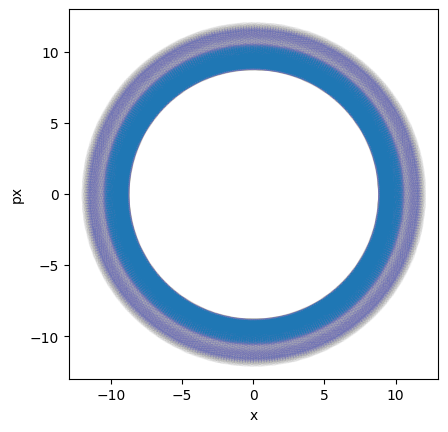

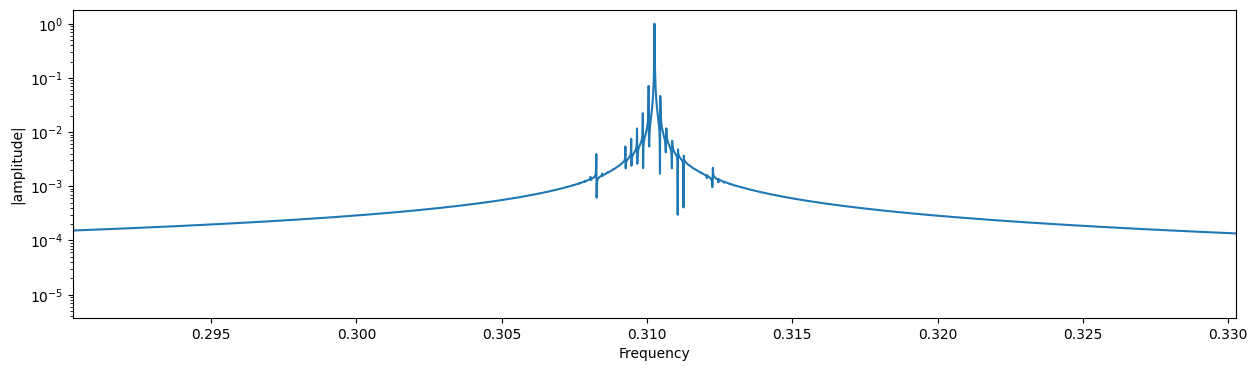

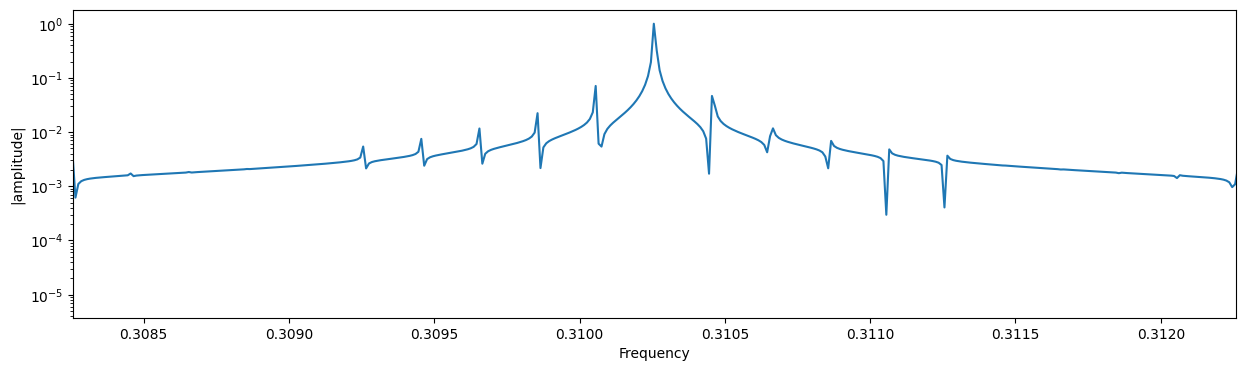

In [118]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sys
import scipy.stats as sciStat


import PySUSSIX.f90sussix.f90sussix as f90sussix
from PySUSSIX.f90sussix.sussix import  F90Sussix

import PySUSSIX.crosssussix.crossroutines as crossroutines
import PySUSSIX.crosssussix.crosssussix as crosssussix
import PySUSSIX.crosssussix.crossref as crossref

import PySUSSIX.ducksussix.ducksussix as ducksussix


# Creating dummy x,px
def get_FFT(x):
    x     = np.array(x)
    turns = np.arange(1,len(x)+1)

    freq  = np.fft.fftfreq(turns.shape[-1])
    spectrum = np.fft.fft(x-np.mean(x))

    idx      = np.argmax(np.abs(spectrum))
    Qx       = freq[idx]
    return freq[freq>0],np.abs(spectrum)[freq>0]



Q0 = 0.3102579387508984
Qs = 0.002
dQ = Qs/10
Jx = (0.5*(10**2))

n_bands_Qs = 1
n_bands_dQ = 5
N   = np.arange(int(1e5) - 5)
j   = np.arange(-n_bands_Qs,n_bands_Qs+1)
i   = np.arange(-n_bands_dQ,n_bands_dQ+1)



Ai  = sciStat.cauchy.pdf(i/np.max(i),0,0.05)
Aj  = sciStat.cauchy.pdf(j/np.max(j),0,0.05)
Ai  = Ai/np.max(Ai)
Aj  = Aj/np.max(Aj)
np.random.seed(0)
phii = np.zeros(len(i))#np.random.uniform(-np.pi/2,np.pi/2,len(i))
phij = np.zeros(len(j))#np.random.uniform(-np.pi/2,np.pi/2,len(j)) 
# x = sum([sum([ _Ai*_Aj * np.sin(2*np.pi*(Q0+ _j*Qs + _i*dQ)*N) for _i,_Ai in zip(i,Ai) ]) for _j,_Aj in zip(j,Aj) ])
hx_full = sum([sum([ np.sqrt(2*Jx)*_Ai*_Aj * np.exp(1j*2*np.pi*(Q0+ _j*Qs + _i*dQ)*N + _phii + _phij) for _i,_Ai,_phii in zip(i,Ai,phii) ]) for _j,_Aj,_phij in zip(j,Aj,phij) ])
x  = hx_full.real
px = hx_full.imag

expected = pd.DataFrame({'amplitude':np.array([[ (np.sqrt(2*Jx)*_Ai*_Aj) for _i,_Ai,_phii in zip(i,Ai,phii) ] for _j,_Aj,_phij in zip(j,Aj,phij) ]).flatten(),
                         'frequency':np.array([[Q0+ _j*Qs + _i*dQ for _i,_Ai,_phii in zip(i,Ai,phii) ] for _j,_Aj,_phij in zip(j,Aj,phij) ]).flatten()})
expected.sort_values(by='amplitude',ascending=False,inplace=True)
expected.reset_index(drop=True,inplace=True)
plt.figure()
plt.plot(x,px,'o',alpha=0.002)
plt.axis('square')
plt.xlabel('x')
plt.ylabel('px')


plt.figure(figsize=(15,4))
freq,spectrum = get_FFT(x)
plt.plot(freq,spectrum/np.max(spectrum),'-')
plt.yscale('log')
plt.xlim(Q0-10*Qs,Q0+10*Qs)
plt.xlabel('Frequency')
plt.ylabel('|amplitude|')

plt.figure(figsize=(15,4))
freq,spectrum = get_FFT(x)
plt.plot(freq,spectrum/np.max(spectrum),'-')
plt.yscale('log')
# plt.xlim(Q0-10*dQ,Q0+10*dQ)
plt.xlim(Q0-1*Qs,Q0+1*Qs)
plt.xlabel('Frequency')
plt.ylabel('|amplitude|')

# display(expected)


---
# Schmidt
---

In [2]:
def zfun(tune, z, maxn):
    # Implementation of the function z(tune)
    # Modify this based on your actual function
    ztune = np.exp(-1j * 2 * np.pi * tune)
    return np.polyval(z[::-1], ztune)

---
# Wolski's approach!
---


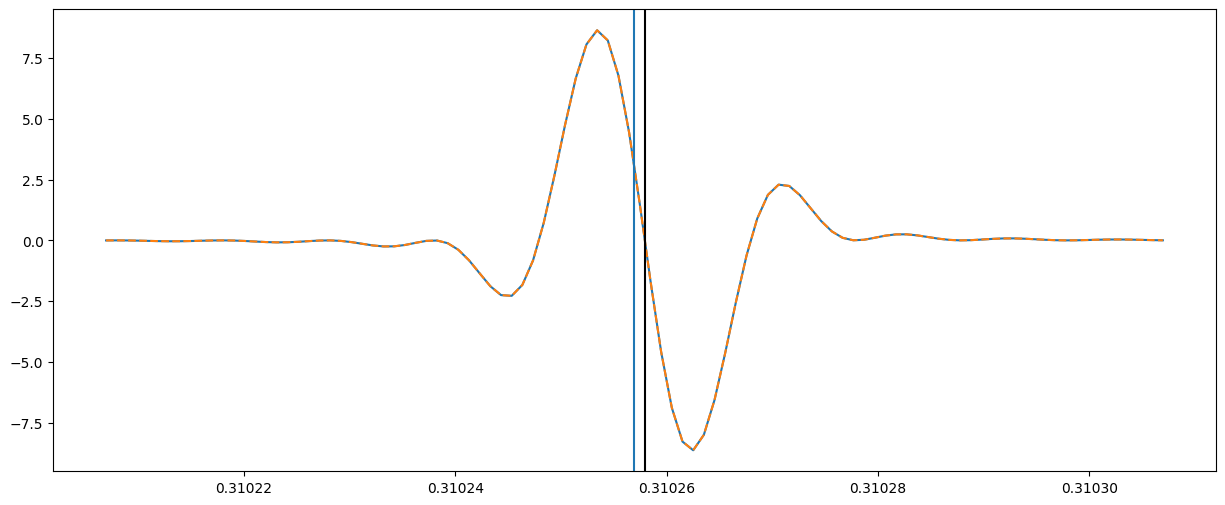

In [5]:
Hann_order = 1
x,px       = hx_full.real,hx_full.imag

# Windowing of the signal
N   = np.arange(len(x))# + 1
Nt  = len(x)
z   = np.array(x) + 1j*np.array(px)
z_w = z * ducksussix.Hann(N, Nt=len(z),p=Hann_order)
    
# Estimation of the tune with FFT
tune_est,resolution = ducksussix.FFT_tune_estimate(z_w)

# Optimizer:
freqs = np.linspace(tune_est-0.5e-4,tune_est+0.5e-4,100)



def Laskar_DFFT(freq,N,z):
    """
    Discrete fourier transform of z, as defined in A. Wolski, Sec. 11.5.
    In a typical DFFT , freq = m/Nt where m is an integer. Here m could take any value.
    ----------------------------------------------------
        freq: discrete frequency to evaluate the DFFT at
        N   : turn numbers of the signal
        z   : complex array of the signal
    ----------------------------------------------------
    """
    Nt = len(z)
    return sum(1/Nt*np.exp(-2*np.pi*1j*freq*N)*z)

# y_wolski  = np.imag(np.array([Laskar_DFFT(freq,N-1,z_w) for freq in freqs]))
# y_schmidt = np.imag(np.array([zfun(freq, z_w, len(z_w)) for freq in freqs]))
y_wolski  = np.imag(np.array([ducksussix.Laskar_DFFT(freq,N,z_w) for freq in freqs]))
y_schmidt = np.imag(np.array([zfun(freq, z_w, len(z_w)) for freq in freqs]))

plt.figure(figsize=(15,6))
plt.plot(freqs,y_wolski)
plt.plot(freqs,y_schmidt/Nt,'--')#/np.max(y_schmidt)) 
plt.axvline(tune_est)
plt.axvline(Q0,color='k')


In [63]:
N

array([    0,     1,     2, ..., 99997, 99998, 99999])

---
# Newton optimizer
---

In [130]:
import numpy as np

def Laskar_DFFT(freq,N,z):
    Nt = len(z)
    return sum(1/Nt*1*np.exp(-2*np.pi*1j*freq*N)*z)

def Laskar_DFFT_derivative(freq,N,z):
    Nt = len(z)
    deriv_factor = 1j*N
    return sum(1/Nt*deriv_factor*1*np.exp(-2*np.pi*1j*freq*N)*z)



Hann_order = 1
x,px       = hx_full.real,hx_full.imag

import math
def Hann(N,Nt = None,p=1):
    """Hann's window, centered at the middle of the dataset.
        N : index of the turn
        Nt: total number of turns
    """
    if Nt is None:
        Nt = np.max(N)
    if np.mod(Nt,2) == 0:
        center = Nt//2 - 1
    else:
        center = Nt//2
    return (2**p)*math.factorial(p)**2/(math.factorial(2*p)) * (1+np.cos(2*np.pi*(N-center)/Nt))**(p)



# Windowing of the signal
N   = np.arange(len(x))
z   = np.array(x) + 1j*np.array(px)
z_w = z * Hann(N, Nt=len(z),p=Hann_order)
    
# Estimation of the tune with FFT
tune_est,resolution = ducksussix.FFT_tune_estimate(z_w)

# Optimizer:
freqs = np.linspace(tune_est-0.5e-4,tune_est+0.5e-4,1000)


# newton_method(z_w,N,tune_est,resolution)

z = z_w

# Increase resolution by factor 5
resolution /= 5

tune_test = np.zeros(10)
tune_val  = np.zeros(10)


DFFT   = Laskar_DFFT(tune_est,N,z)
DFFT_d = Laskar_DFFT_derivative(tune_est,N,z)
dtunea1 = DFFT.real*DFFT_d.real + DFFT.imag*DFFT_d.imag


# old name
tunea1 = tune_est
deltat = resolution
err    = 1e-10
num    = 0
# print('loop entry :',tune_est)

DFFT   = Laskar_DFFT(tunea1,N,z)
DFFT_d = Laskar_DFFT_derivative(tunea1,N,z)

print('dfft:',DFFT,DFFT_d)
dtunea1 = DFFT.real*DFFT_d.real + DFFT.imag*DFFT_d.imag



tunea2 = 0
dtunea2 = 0
# print('before all:',tunea1, tunea2, dtunea1, dtunea2)
for ntest in range(1, 11):
    tunea2 = tunea1+deltat

    DFFT   = Laskar_DFFT(tunea2,N,z)
    DFFT_d = Laskar_DFFT_derivative(tunea2,N,z)
    dtunea2 = DFFT.real*DFFT_d.real + DFFT.imag*DFFT_d.imag

    # print('condition:',dtunea1,dtunea2)
    if (dtunea1 <= 0) and (dtunea2 >= 0):
        tune1, tune2, dtune1, dtune2 = tunea1, tunea2, dtunea1, dtunea2

        # print('loop entry :',tune1, tune2, dtune1, dtune2)
        for ncont in range(1, 101):
            ratio = -dtune1 / dtune2 if abs(dtune2) > 0 else 0.0

            tune3 = (tune1 + ratio * tune2) / (1.0 + ratio)

            
            DFFT   = Laskar_DFFT(tune3,N,z)
            DFFT_d = Laskar_DFFT_derivative(tune3,N,z)
            dtune3 = DFFT.real*DFFT_d.real + DFFT.imag*DFFT_d.imag


            if dtune3 <= 0.0:
                if tune1 == tune3:
                    break
                tune1, dtune1 = tune3, dtune3
            else:
                if tune2 == tune3:
                    break
                tune2, dtune2 = tune3, dtune3

            if abs(tune2 - tune1) <= err:
                break

        
        tune_test[num] = tune3
        tune_val[num]  = np.abs(DFFT)
        num += 1
        print('allo     :',list(tune_test))


    tunea1, dtunea1 = tunea2, dtunea2

idx_max = np.argmax(tune_val[:num])
tune      = tune_test[idx_max]
amplitude = Laskar_DFFT(tune,N,z)


tune_zfun,zw_zfun = crossroutines.zfunr(z_w,tune_est)

dfft: (9.470182317895626+3.0136389033847713j) (-169761.24359275424+467406.3481679926j)
allo     : [0.3102579387508984, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
allo     : [0.3102579387508984, 0.31028155916408307, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
 test:  0.31025793875089835        0.0000000000000000        0.0000000000000000        0.0000000000000000        0.0000000000000000        0.0000000000000000        0.0000000000000000        0.0000000000000000        0.0000000000000000        0.0000000000000000     
 test:  0.31025793875089835       0.31028155916408312        0.0000000000000000        0.0000000000000000        0.0000000000000000        0.0000000000000000        0.0000000000000000        0.0000000000000000        0.0000000000000000        0.0000000000000000     


In [135]:
center = (int(10e5) - 5)//2
center

499997

In [131]:
print(Q0)
print(tune)
print(tune_zfun)

0.3102579387508984
0.3102579387508984
0.31025793875089835


In [100]:
# a = 0.3102579387508983
# print(f'{a:.20f}')

0.31025793875089829887


In [132]:
print(amplitude)
print(zw_zfun)

(10.000000159919427+8.755185298640426e-16j)
(999950.0159918764+2.2414646018504126e-05j)


In [126]:
print(amplitude)
print(zw_zfun)

(10.000000159919427+8.755185298640426e-16j)
(999950.0159918764+2.2414646018504126e-05j)


9.944261677368162

In [32]:
Q0

0.31025793875089835

In [23]:
zw_zfun

(1000000.0000007827+2.154541739526195e-07j)

In [30]:
print(tune)
print(Q0)


0.31027536001184375
0.31025793875089835


In [25]:
 np.argmax(tune_val[:num])

0

In [18]:
%%timeit
a.real

31.5 ns ± 0.0241 ns per loop (mean ± std. dev. of 7 runs, 10,000,000 loops each)


In [14]:
a = 5 + 2*1j
b = 2 + 3*1j

print(np.vdot(a,b))
print(a.real*b.real + a.imag*b.imag)

(16+11j)
16.0
